In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Ucitavanje baze i njeno analiziranje:

In [2]:
data = pd.read_csv('diabetic_data.csv',na_values='*')
naziv_atributa = data.columns
#for col in naziv_atributa:
#    print(col)

In [3]:
data.shape

(101766, 50)

In [4]:
#da bih na jednom mestu imala koji su to sve kategoricki a koji su numericki atributi, radim sledece

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
print('Numericki podaci su:\n')
for num in numerical_cols:
    print(num)
    
print('\n')
    
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print('Kategoricki podaci su:\n')
for cat in categorical_cols:
    print(cat)

Numericki podaci su:

encounter_id
patient_nbr
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
number_diagnoses


Kategoricki podaci su:

race
gender
age
weight
payer_code
medical_specialty
diag_1
diag_2
diag_3
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


# Pretprocesiranje

In [5]:
#readmitted(ponovni prijem) - indikator da li je pacijent ponovo 
#primljen u bolnicu u roku od 30 dana nakon prvog prijema

#gledamo balansiranost podataka
broj_klasa = data['readmitted'].value_counts()
broj_klasa

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [6]:
#da bih imala 2 a ne tri klase radi lakseg rada(a i bolje tacnosti sto se
# kasnije pokazalo tako) spajam <30 i >30 klase u jednu
data['readmitted'] = data['readmitted'].replace({'>30': 're-admitted', '<30': 're-admitted'})

In [7]:
broj_klasa = data['readmitted'].value_counts()
broj_klasa

NO             54864
re-admitted    46902
Name: readmitted, dtype: int64

### Nedostajuce vrednosti

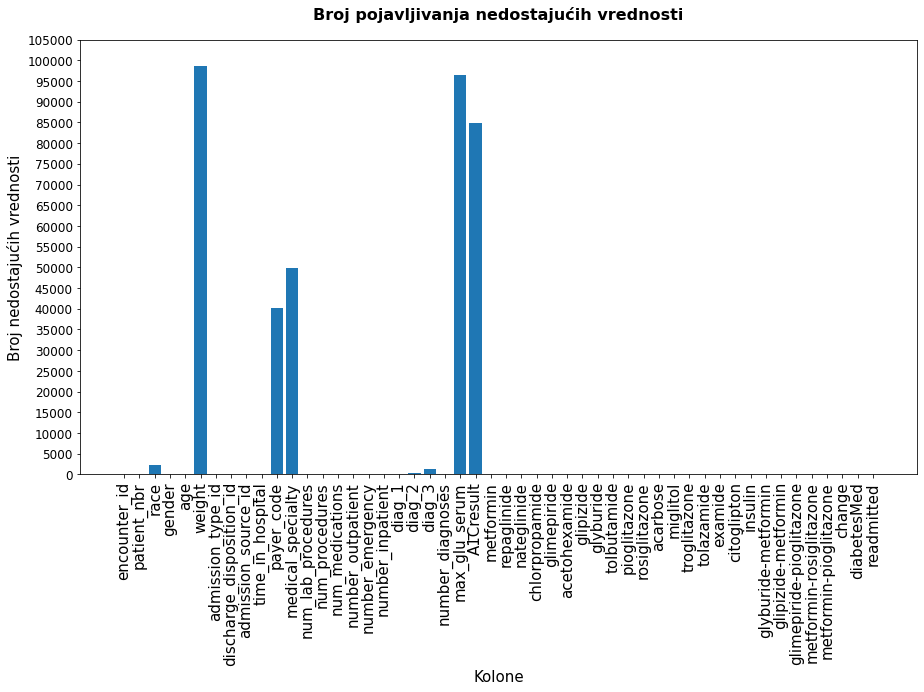

In [8]:
nedostajuce = data.isin(['?', 'None', 'nan']).sum()

plt.figure(figsize=(15, 8))
plt.bar(nedostajuce.index, nedostajuce.values)

plt.title('Broj pojavljivanja nedostajućih vrednosti', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Kolone',fontsize=15)
plt.ylabel('Broj nedostajućih vrednosti',fontsize=15)

plt.xticks(rotation=90,fontsize=15)
plt.yticks(np.arange(0, 110000,5000), fontsize=12)

plt.show()

In [9]:
#for x in categorical_cols:
#    print(data[x].unique())

In [10]:
upitnik = (data == '?').any(axis=0)
print(upitnik[upitnik])


race                 True
weight               True
payer_code           True
medical_specialty    True
diag_1               True
diag_2               True
diag_3               True
dtype: bool


In [11]:
none_vrednosti=(data =='None').any(axis=0)
print(none_vrednosti[none_vrednosti])

max_glu_serum    True
A1Cresult        True
dtype: bool


Po ovome smo jos jednom potvrdili da su atributi:race, weight, payer_code, medical_specialty, 
diag_1, diag_2 ,diag_3, max_glu_serum, A1Cresult  oni atributi koji koji imaju nedostajuce vrednosti.                     
Međutim, neki od ovih atributa mogu biti manje relevantni za ciljnu varijablu "readmitted", kao što su race, 
weight i payer_code(kod osiguravajuće kompanije), pa bi se mogli izostaviti iz skupa atributa. 
S druge strane, atributi diag_1(primarna dijagnoza), diag_2(sekundarna dijagnoza), diag_3(tercijarna dijagnoza),
max_glu_serum(najvisa izmerena glikemija) i A1Cresult(prosecna glikemija) mogu biti važni jer se tiču dijagnostike i tretmana dijabetesa,
što može biti povezano sa ponovnim prijemom u bolnicu.


In [12]:
# Popunjavanje nedostajućih vrednosti sa najčešćom vrednošću u koloni(jer su ovi "bitni" atributi relevantni
# i vazni za nasu bazu i za razmatranje ponovnog prijema u bolnicu)

bitni=['diag_1', 'diag_2', 'diag_3', 'max_glu_serum' ,'A1Cresult']


for b in bitni:
    most_frequent_value = data[b].mode().values[0]
    data[b] = data[b].replace(['?', 'None'], most_frequent_value)

In [13]:
data.drop(['race','weight','payer_code','medical_specialty','encounter_id','patient_nbr', 'examide', 'citoglipton'], axis=1,inplace=True)
# 'examide', 'citoglipton'- obrisani jer imaju samo vrednost 'No'

In [14]:
#kategoricki atributi posle brisanja pojedinih:
categorical_cols2 = data.select_dtypes(include=['object', 'category']).columns
print('Kategoricki podaci su:\n')
for cat in categorical_cols2:
    print(cat)

Kategoricki podaci su:

gender
age
diag_1
diag_2
diag_3
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


### Konvertovanje kategorickih podataka u numericke radi lakseg rada nad podacima
OneHotEncoder je pravio veci problem od LabelEncodera, zbog mnogo duzeg rada na podacima i malo gore tacnosti

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for c in categorical_cols2:
    data[c] = label_encoder.fit_transform(data[c])

In [16]:
data.describe()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,0.462443,6.096702,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,...,0.000393,1.405469,1.006898,0.000128,0.000010,0.000020,0.000010,0.538048,0.770031,0.460881
std,0.498649,1.594084,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,...,0.020312,0.838798,0.084414,0.011302,0.003135,0.004433,0.003135,0.498553,0.420815,0.498470
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,6.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,7.000000,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,...,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,2.000000,9.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,...,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
data.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,0,0,6,25,1,1,41,0,1,0,...,0,1,1,0,0,0,0,1,0,0
1,0,1,1,1,7,3,59,0,18,0,...,0,3,1,0,0,0,0,0,1,1
2,0,2,1,1,7,2,11,5,13,2,...,0,1,1,0,0,0,0,1,1,0
3,1,3,1,1,7,2,44,1,16,0,...,0,3,1,0,0,0,0,0,1,0
4,1,4,1,1,7,1,51,0,8,0,...,0,2,1,0,0,0,0,0,1,0


In [18]:
X = data.drop(['readmitted'], axis=1)
y = data['readmitted']
print(X.shape,y.shape)

(101766, 41) (101766,)


### Rad sa outlier-ima preko IQR-a i boxplot-ovanje i kasnije brisanje outlier-a

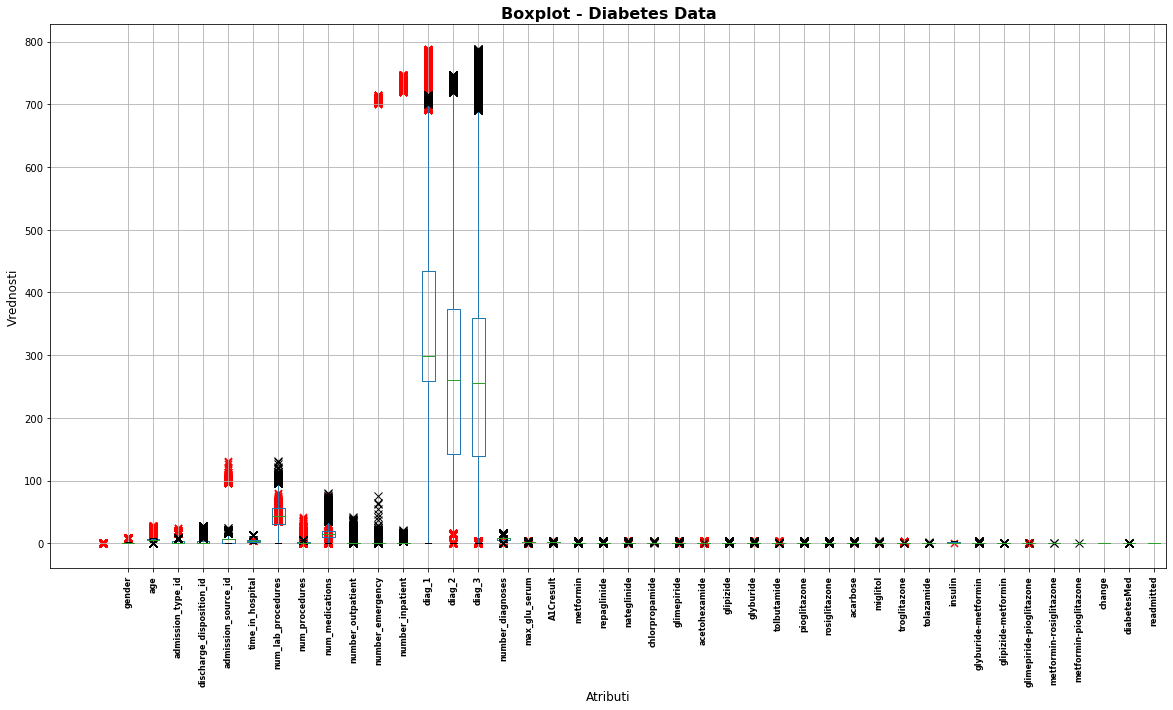

In [19]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90, va='top', fontsize=7, fontweight='bold')
data.boxplot(showfliers=True, flierprops=dict(marker='x', markerfacecolor='blue', markersize=8))

# Podešavanje naslova i oznaka osa
plt.title('Boxplot - Diabetes Data', fontsize=16, fontweight='bold')
plt.xlabel('Atributi', fontsize=12)
plt.ylabel('Vrednosti', fontsize=12)
plt.xticks(rotation='vertical', fontsize=8)


# Prikazivanje IQR raspona
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Prikazivanje vrednosti outliera
for col in data.columns:
    outliers = ((data[col] < lower_bound[col]) | (data[col] > upper_bound[col]))
    if outliers.any():
        x = [col] * outliers.sum()
        yy = data.loc[outliers, col]
        plt.scatter(x, yy, c='red', marker='x', s=50)

# Prikazivanje boxplot-a
plt.show()

In [20]:
data=data[~outliers]
#brisanje outlier-a

### Graficki prikaz korelisanosti izmedju atributa
Kao sto mozemo videti na grafikonu, korelisanost izmedju atributa skoro pa i da ne postoji, sto znaci da preko 
matrice korelacije ne mozemo da vidimo koje bismo atribute jos mogli eventualno da obrisemo

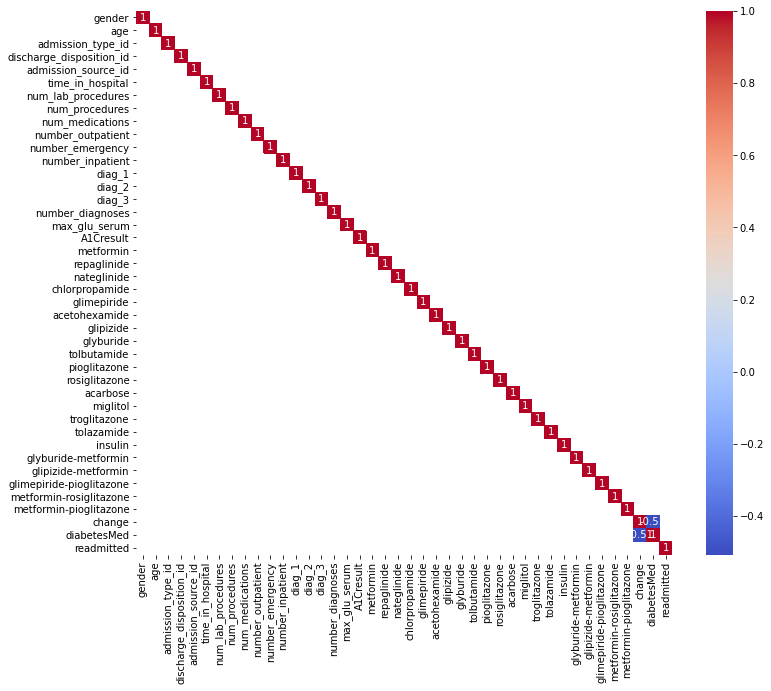

In [21]:
import seaborn as sns

matrica_korelacije = data.corr()

prag = 0.5

korelisani = matrica_korelacije.abs() > prag
korelisani_matrica = matrica_korelacije[korelisani]

plt.figure(figsize=(12, 10))

sns.heatmap(korelisani_matrica, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


# Pripema podataka za klasifikaciju - podela na trening i test skupove:

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,plot_roc_curve

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

Normalizacija podataka 

In [24]:
normalizer = Normalizer()
scaler = StandardScaler()

In [25]:
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [26]:
#X_train_normalized

## Primena prvog algoritma - Stablo odlucivanja


### GridSearch

Pretraživanje različitih kombinacija hiperparametara modela kako bi se pronašla najbolja kombinacija koja daje najbolje rezultate.

In [27]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}


In [28]:
gs = GridSearchCV(DecisionTreeClassifier(),
             param_grid=param_grid_tree,
             scoring='accuracy',
             cv=4,
             verbose=5)

In [29]:
gs.fit(X_train_normalized, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] criterion=gini, max_depth=None, min_samples_split=2 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=None, min_samples_split=2, score=0.565, total=   1.0s
[CV] criterion=gini, max_depth=None, min_samples_split=2 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_split=2, score=0.562, total=   1.0s
[CV] criterion=gini, max_depth=None, min_samples_split=2 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_split=2, score=0.564, total=   1.0s
[CV] criterion=gini, max_depth=None, min_samples_split=2 .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_split=2, score=0.561, total=   1.0s
[CV] criterion=gini, max_depth=None, min_samples_split=5 .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=None, min_samples_split=5, score=0.567, total=   0.9s
[CV] criterion=gini, max_depth=None, min_samples_split=5 .............
[CV]  criterion=gini, max_depth=None, min_samples_split=5, score=0.564, total=   0.9s
[CV] criterion=gini, max_depth=None, min_samples_split=5 .............
[CV]  criterion=gini, max_depth=None, min_samples_split=5, score=0.568, total=   0.9s
[CV] criterion=gini, max_depth=None, min_samples_split=5 .............
[CV]  criterion=gini, max_depth=None, min_samples_split=5, score=0.562, total=   0.9s
[CV] criterion=gini, max_depth=None, min_samples_split=10 ............
[CV]  criterion=gini, max_depth=None, min_samples_split=10, score=0.568, total=   0.9s
[CV] criterion=gini, max_depth=None, min_samples_split=10 ............
[CV]  criterion=gini, max_depth=None, min_samples_split=10, score=0.570, total=   0.9s
[CV] criterion=gini, max_depth=None, min_samples_split=10 ............
[CV]  criterion=gini, max_depth=None, min_samples_split=

[CV]  criterion=entropy, max_depth=None, min_samples_split=10, score=0.567, total=   1.1s
[CV] criterion=entropy, max_depth=None, min_samples_split=10 .........
[CV]  criterion=entropy, max_depth=None, min_samples_split=10, score=0.568, total=   1.0s
[CV] criterion=entropy, max_depth=None, min_samples_split=10 .........
[CV]  criterion=entropy, max_depth=None, min_samples_split=10, score=0.562, total=   1.1s
[CV] criterion=entropy, max_depth=5, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=5, min_samples_split=2, score=0.631, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=5, min_samples_split=2, score=0.622, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=5, min_samples_split=2, score=0.632, total=   0.3s
[CV] criterion=entropy, max_depth=5, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=5, min_samp

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.1min finished


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=5)

In [30]:
print(gs.best_estimator_)
print(gs.best_score_)
print(gs.best_params_)

DecisionTreeClassifier(criterion='entropy', max_depth=5)
0.6288262172652681
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}


### Moj izbor

In [31]:
model = DecisionTreeClassifier(max_depth=5,criterion='gini')

In [32]:
model.fit(X_train_normalized,y_train)

DecisionTreeClassifier(max_depth=5)

In [33]:
y_pred = model.predict(X_test_normalized)

In [34]:
confusion_matrix(y_test,y_pred)

array([[8056, 2917],
       [4588, 4793]])

In [35]:
a1=accuracy_score(y_test, y_pred)
a1

0.6312764075857326

## Primena drugog algoritma - RandomForestClassifier(slucajne sume)

### GridSearch

In [36]:
param_grid_forest = {
    'n_estimators': [100, 200, 300],  # Broj estimatora (stabala) u slučajnoj šumi
    'max_depth': [None, 5, 10],  # Maksimalna dubina stabala
    'min_samples_split': [2, 5, 10],  # Minimalni broj uzoraka za razdvajanje čvora
}

gss = GridSearchCV(RandomForestClassifier(),
             param_grid=param_grid_forest,
             scoring='accuracy',
             cv=4,
             verbose=5)


In [37]:
gss.fit(X_train_normalized, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV] max_depth=None, min_samples_split=2, n_estimators=100 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, min_samples_split=2, n_estimators=100, score=0.636, total=  13.8s
[CV] max_depth=None, min_samples_split=2, n_estimators=100 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=2, n_estimators=100, score=0.632, total=  14.2s
[CV] max_depth=None, min_samples_split=2, n_estimators=100 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.0s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=2, n_estimators=100, score=0.636, total=  13.6s
[CV] max_depth=None, min_samples_split=2, n_estimators=100 ...........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.6s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=2, n_estimators=100, score=0.641, total=  13.5s
[CV] max_depth=None, min_samples_split=2, n_estimators=200 ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   55.1s remaining:    0.0s


[CV]  max_depth=None, min_samples_split=2, n_estimators=200, score=0.640, total=  27.6s
[CV] max_depth=None, min_samples_split=2, n_estimators=200 ...........
[CV]  max_depth=None, min_samples_split=2, n_estimators=200, score=0.635, total=  27.7s
[CV] max_depth=None, min_samples_split=2, n_estimators=200 ...........
[CV]  max_depth=None, min_samples_split=2, n_estimators=200, score=0.641, total=  26.7s
[CV] max_depth=None, min_samples_split=2, n_estimators=200 ...........
[CV]  max_depth=None, min_samples_split=2, n_estimators=200, score=0.640, total=  26.9s
[CV] max_depth=None, min_samples_split=2, n_estimators=300 ...........
[CV]  max_depth=None, min_samples_split=2, n_estimators=300, score=0.641, total=  39.0s
[CV] max_depth=None, min_samples_split=2, n_estimators=300 ...........
[CV]  max_depth=None, min_samples_split=2, n_estimators=300, score=0.639, total=  39.1s
[CV] max_depth=None, min_samples_split=2, n_estimators=300 ...........
[CV]  max_depth=None, min_samples_split=2, n_e

[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.631, total=  11.7s
[CV] max_depth=5, min_samples_split=5, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.625, total=  11.8s
[CV] max_depth=5, min_samples_split=5, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.636, total=  11.9s
[CV] max_depth=5, min_samples_split=5, n_estimators=300 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=300, score=0.633, total=  11.7s
[CV] max_depth=5, min_samples_split=10, n_estimators=100 .............
[CV]  max_depth=5, min_samples_split=10, n_estimators=100, score=0.631, total=   3.8s
[CV] max_depth=5, min_samples_split=10, n_estimators=100 .............
[CV]  max_depth=5, min_samples_split=10, n_estimators=100, score=0.625, total=   3.9s
[CV] max_depth=5, min_samples_split=10, n_estimators=100 .............
[CV]  max_depth=5, min_samples_split=10, n_estimators=100, sco

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 27.5min finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=5)

In [38]:
print(gss.best_estimator_)
print(gss.best_score_)
print(gss.best_params_)

RandomForestClassifier(min_samples_split=10, n_estimators=300)
0.6418218444455362
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}


### Moj izbor

In [39]:
model2 = RandomForestClassifier()

In [61]:
model2= RandomForestClassifier(min_samples_split=10, n_estimators=300)

In [62]:
model2.fit(X_train_normalized,y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=300)

In [63]:
y_pred2 = model2.predict(X_test_normalized)

In [64]:
confusion_matrix(y_test,y_pred2)

array([[8133, 2840],
       [4457, 4924]])

In [65]:
a2=accuracy_score(y_test, y_pred2)
a2

0.6414955291343225

## Primena treceg algoritma - GradientBoostingClassifier

### GridSearch

In [78]:
param_grid_gradient = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}


gsss = GridSearchCV(GradientBoostingClassifier(),
             param_grid=param_grid_gradient,
             scoring='accuracy',
             cv=4,
             verbose=5)


In [79]:
gsss.fit(X_train_normalized, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100, score=0.636, total=  19.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100, score=0.636, total=  18.7s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.2s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100, score=0.643, total=  19.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.3s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=100, score=0.639, total=  18.9s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200, score=0.644, total=  38.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200, score=0.640, total=  37.6s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200, score=0.648, total=  38.0s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=200, score=0.642, total=  37.4s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300, score=0.645, total=  56.9s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=2, n_estimators=300, score=0.643, total=  56

[CV]  learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=100, score=0.649, total=  29.3s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=100, score=0.644, total=  29.2s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200, score=0.648, total=  59.8s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200, score=0.645, total=  59.1s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200, score=0.649, total=  59.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=4, n_estimators=200, score=0.644, total=  59

[CV]  learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100, score=0.647, total=  40.2s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100, score=0.643, total=  39.5s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100, score=0.647, total=  39.8s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=100, score=0.643, total=  39.8s
[CV] learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=200, score=0.646, total= 1.4min
[CV] learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=7, min_samples_split=6, n_estimators=200, score=0.641, total= 1.3

[CV]  learning_rate=0.05, max_depth=3, min_samples_split=6, n_estimators=300, score=0.647, total=  56.2s
[CV] learning_rate=0.05, max_depth=3, min_samples_split=6, n_estimators=300 
[CV]  learning_rate=0.05, max_depth=3, min_samples_split=6, n_estimators=300, score=0.642, total=  55.5s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, score=0.640, total=  28.9s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, score=0.636, total=  28.5s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, score=0.643, total=  28.9s
[CV] learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=100, score=0.642,

[CV]  learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300, score=0.647, total= 2.0min
[CV] learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300 
[CV]  learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300, score=0.643, total= 2.0min
[CV] learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300 
[CV]  learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300, score=0.650, total= 2.0min
[CV] learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300 
[CV]  learning_rate=0.05, max_depth=7, min_samples_split=2, n_estimators=300, score=0.645, total= 2.0min
[CV] learning_rate=0.05, max_depth=7, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=7, min_samples_split=4, n_estimators=100, score=0.643, total=  39.0s
[CV] learning_rate=0.05, max_depth=7, min_samples_split=4, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=7, min_samples_split=4, n_estimators=100, score=0.641,

[CV]  learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=200, score=0.631, total=  37.1s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=200, score=0.628, total=  36.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300, score=0.632, total=  55.5s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300, score=0.625, total=  55.1s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300, score=0.635, total=  55.6s
[CV] learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300 
[CV]  learning_rate=0.01, max_depth=3, min_samples_split=4, n_estimators=300, score=0.634,

[CV]  learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200, score=0.634, total=  56.7s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200, score=0.629, total=  56.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200, score=0.637, total=  57.0s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=200, score=0.634, total=  56.2s
[CV] learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300, score=0.637, total= 1.4min
[CV] learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300 
[CV]  learning_rate=0.01, max_depth=5, min_samples_split=6, n_estimators=300, score=0.631,

[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed: 313.3min finished


GridSearchCV(cv=4, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=5)

In [80]:
print(gsss.best_estimator_)
print(gsss.best_score_)
print(gsss.best_params_)

GradientBoostingClassifier(max_depth=5, n_estimators=300)
0.6482828084311896
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}


### Moj izbor

In [85]:
model3 = GradientBoostingClassifier()

In [86]:
model3=GradientBoostingClassifier(max_depth=5, n_estimators=300)

In [87]:
model3.fit(X_train_normalized,y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=300)

In [88]:
y_pred3 = model3.predict(X_test_normalized)

In [89]:
confusion_matrix(y_test,y_pred3)

array([[8097, 2876],
       [4198, 5183]])

In [90]:
a3=accuracy_score(y_test, y_pred3)
a3

0.6524516065638204

## Accuracy za sva tri modela

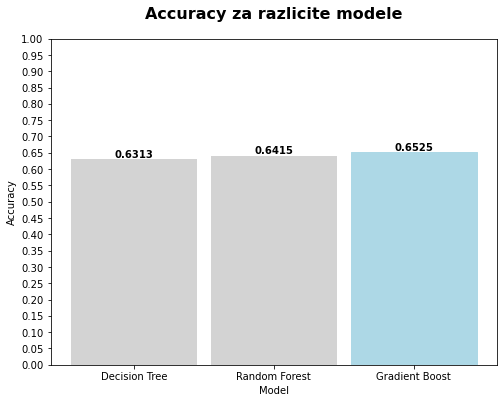

In [91]:
modeli = ['Decision Tree', 'Random Forest', 'Gradient Boost']

accuracy_scores = [a1,a2,a3]
plt.figure(figsize=(8, 6))
bars = plt.bar(modeli, accuracy_scores, width=0.9, color=['lightgray', 'lightgray', 'lightgray'])

#plt.bar(modeli, accuracy_scores,width=0.9,color='lightgray')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy za razlicite modele',fontsize=16, fontweight='bold', pad=20)
plt.ylim([0, 1])  
plt.yticks([i/100 for i in range(0, 101, 5)])
max_index = accuracy_scores.index(max(accuracy_scores))
bars[max_index].set_color('lightblue')
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', color='black', fontweight='bold')

plt.show()

## Poredjenje modela preko ROC krive

Text(0, 0.5, 'Tačno pozitivna stopa (TPR)')

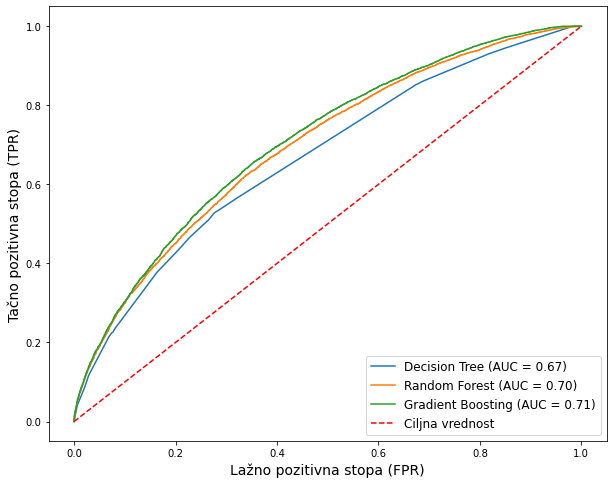

In [92]:
fig, ax = plt.subplots(figsize=(10, 8))

plot_roc_curve(model, X_test_normalized, y_test, ax=ax, name='Decision Tree')
plot_roc_curve(model2, X_test_normalized, y_test, ax=ax, name='Random Forest')
plot_roc_curve(model3, X_test_normalized, y_test, ax=ax, name='Gradient Boosting')
fpr = np.linspace(0, 1, 100)
tpr = fpr
plt.plot(fpr, tpr, linestyle='--', color='red', label='Ciljna vrednost')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Lažno pozitivna stopa (FPR)', fontsize=14)
plt.ylabel('Tačno pozitivna stopa (TPR)', fontsize=14)
